## Task 1

In [1]:
# !pip install segmentation-models-pytorch
# !pip install-U git+https://github.com/albumentations-team/albumentations

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


## Task 2 : Setup Configurations

In [3]:
CSV_FILE = "./Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = '../Coursera'
DEVICE = 'cuda'
EPOCHS  = 25 
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [6]:
row = df.iloc[1]

In [7]:
image_path = row.images
mask_path = row.masks

In [8]:
import cv2

In [9]:
image = cv2.imread(image_path)

In [10]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [11]:
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


Figure(720x360)


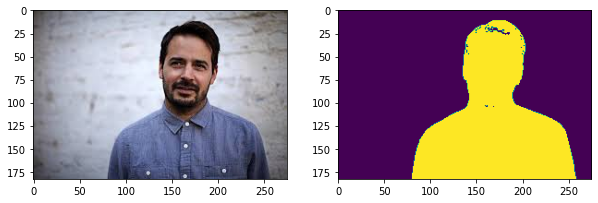

In [12]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(image)
ax2.imshow(mask)
print(f)

## Task 3 : Augmentation Function 

In [13]:
import albumentations as A

In [14]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

## Task 4 : Custom Dataset

In [15]:
from torch.utils.data import Dataset
import numpy as np
import torch

In [16]:
from typing import Any


class SegmentationDatataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   # h , w, c 
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image , mask= mask)
            image = data['image']
            mask = data['mask']

    # (h,w, c) -> (c, w, h)
        image = np.transpose(image, (2, 0 ,1 )).astype(np.float32)
        mask = np.transpose(mask, (2, 0 ,1 )).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask)/255.0)
        
        return image , mask

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state =42)

In [19]:
trainset = SegmentationDatataset(train_df , get_train_augs())
validset = SegmentationDatataset(valid_df , get_valid_augs())

In [20]:
print(len(trainset))
print(len(validset))

232
58


In [21]:
import helper
idx = 12
image, mask = trainset[idx]


In [22]:
# helper.show_image(image, mask)

## Task 5 : Load dataset into batches

In [23]:
from torch.utils.data import DataLoader

In [24]:
trainloader = DataLoader(trainset , batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset , batch_size = BATCH_SIZE)  


In [25]:
print(f"total no. of batches in train  : {len(trainloader)}")
print(f"total no. of batches in valid : {len(validloader)}")

total no. of batches in train  : 15
total no. of batches in valid : 4


In [26]:
for image, mask in trainloader:
    break
print(image.shape)
print(mask.shape)
# 16 -> batch size , no.of channels, height , width


torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


## Task 6 : Segmentation model

In [27]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [31]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER,
            encoder_weights= WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation= None

        )
    
    def forward(self,images, masks = None):
        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [32]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

## Task 7 : Create Train and Validation Function

In [33]:
def train_fn(data_loader , model, optimizer):
    model.train()
    total_loss = 0.0
    
    for images, masks in data_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss/len(data_loader)


In [37]:
def eval_fn(data_loader , model):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)


            total_loss += loss.item()
    return total_loss/len(data_loader)

## TASK 8: TRAIN MODEL

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [38]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loss= train_fn(trainloader,model,optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_model.pth')
        best_valid_loss = valid_loss
    print(f"Epoochs: {i+1} Train_loss:{train_loss} Valid_loss :{valid_loss}" )


Epoochs: 1 Train_loss:0.39034013350804647 Valid_loss :0.3853919059038162
Epoochs: 2 Train_loss:0.31312975684801736 Valid_loss :0.37237150967121124
Epoochs: 3 Train_loss:0.2695506711800893 Valid_loss :0.3558301478624344
Epoochs: 4 Train_loss:0.25019652942816417 Valid_loss :0.26075854152441025
Epoochs: 5 Train_loss:0.23028714060783387 Valid_loss :0.2206823043525219
Epoochs: 6 Train_loss:0.19493907789389292 Valid_loss :0.254299808293581
Epoochs: 7 Train_loss:0.19505643943945566 Valid_loss :0.2477155178785324
Epoochs: 8 Train_loss:0.18571555614471436 Valid_loss :0.2071663998067379
Epoochs: 9 Train_loss:0.1743596206108729 Valid_loss :0.2139650285243988
Epoochs: 10 Train_loss:0.15349888851245244 Valid_loss :0.18921390548348427
Epoochs: 11 Train_loss:0.14526806225379307 Valid_loss :0.1924646981060505
Epoochs: 12 Train_loss:0.1636457100510597 Valid_loss :0.2781185880303383
Epoochs: 13 Train_loss:0.22263367573420206 Valid_loss :0.24625541269779205
Epoochs: 14 Train_loss:0.1507062057654063 Valid

## Task 9 -> Inference

In [ ]:
idx = 20
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # c, h , w  --> 1, c, h, w

pred_mask  = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

NameError: name 'model' is not defined

In [ ]:
helper.show(image, mask, pred_mask.detach().cpu().squeeze(0))